In [4]:
import glob
import random
from typing import Callable, Optional, List

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
from matplotlib import pyplot as plt
from scipy.spatial import distance as distance_calculator
import torch
from torch import Tensor
from torch_geometric import nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.utils import scatter
import seaborn as sn
from torch.nn import Sequential as Seq, Linear as Lin, Dropout, ReLU, BatchNorm1d as BN
from torch_geometric.nn.conv import MessagePassing
from torch_multi_head_attention import MultiHeadAttention
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

#### Loading the data
In each files, the frame numbers are shifted to come after the largest frame number in the previous file. This way all frame numbers are unique.

The dataset contains frames of 1 to 5 people.


In [2]:
random.seed(42)
column_names=['range','azimuth','doppler','snr','x','y','current_frame','seq']

features1: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=np.float64) for filename in glob.glob("data/1/1/*.csv")])
features1.insert(8, "Label", np.zeros(len(features1), dtype=int), True)
max_frame = max(features1["current_frame"])

features2: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=np.float64) for filename in glob.glob("data/2/2/*.csv")])
features2.insert(8, "Label", np.full(len(features2), 1, dtype=int), True)
min_frame = min(features2["current_frame"])
shift = max_frame+10
features2["current_frame"] += shift
max_frame = max(features2["current_frame"])

features3: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=np.float64) for filename in glob.glob("data/3/3/*.csv")])
features3.insert(8, "Label", np.full(len(features3), 2, dtype=int), True)
min_frame = min(features3["current_frame"])
shift = max_frame+10
features3["current_frame"] += shift
max_frame = max(features3["current_frame"])

features4: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=np.float64) for filename in glob.glob("data/4/4/*.csv")])
features4.insert(8, "Label", np.full(len(features4), 3, dtype=int), True)
min_frame = min(features4["current_frame"])
shift = max_frame+10
features4["current_frame"] += shift
max_frame = max(features4["current_frame"])

features5: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=np.float64) for filename in glob.glob("data/bigger/bigger/*.csv")])
features5.insert(8, "Label", np.full(len(features5), 4, dtype=int), True)
min_frame = min(features5["current_frame"])
shift = max_frame+10
features5["current_frame"] += shift
max_frame = max(features5["current_frame"])

features_bikes: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=np.float32) for filename in glob.glob("data/bikes/bikes/*.csv")])
features_bikes.insert(8, "Label", np.full(len(features_bikes), 5, dtype=int), True)
min_frame = min(features_bikes["current_frame"])
shift = max_frame+10
features_bikes["current_frame"] += shift
max_frame = max(features_bikes["current_frame"])

all_data = pd.concat([features1, features2, features3, features4, features5, features_bikes])
all_data.drop_duplicates(subset=['range','azimuth','doppler','snr','y','x','current_frame','Label'], inplace=True, ignore_index=True)
print("Number of data points: "+str(len(all_data)))
print("Largest frame number: "+str(max_frame))

Number of data points: 1064541
Largest frame number: 3489873.0


#### Hyperparameters

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reduced_cols = ['doppler','snr','x','y','current_frame','Label']
column_names=['range','azimuth','doppler','snr','x','y','current_frame','seq', 'Label']
selected_cols = ['doppler','snr','x','y']
SHAPE_NAMES = [0,1,2,3,4, 5]
frame_depths = [5] 
ks = [6]
num_chunks = 16
lr = 0.001
max_epoch = 100
size = 128
EARLY_STOPPING_PATIENCE = 15
train, val, test =[],[],[]


#### Utils

In [6]:
def split_with_chunks(data_array: List[DataFrame], labels: List[int], num_chunks:int, val_frac:float, test_frac:float):
    """
    Divides the dataset into train, test and validition sets. 
    This done by dividing each label's data into n chunks 
    and from each chunk the last val_frac and test_frac amount is moved to validation and test sets.

    :param data_array: The array containing the data
    :param labels: The labels found in the dataset
    :param num_chunks: The number of chunks to divide the data to
    :param val_frac: Fraction of validation set size (between 0 and 1)
    :param test_frac: Fraction of test set size (between 0 and 1)
    :return: The train, validation and test set
    """
    train_frac = 1 - val_frac - test_frac
    train = []
    test = []
    val =[]
    label_values = np.array([data.iloc[0,5] for data in data_array])

    for label in labels:
        itemindex = np.where(label_values == label)
        frames = [data_array[i] for i in itemindex[0]]
        chunk_size = int(len(frames) / num_chunks)
        chunk_indexes = [i*chunk_size for i in range(num_chunks)]
        chunk_indexes.append(len(frames))

        for chunk in range(num_chunks):
            data_chunk = frames[chunk_indexes[chunk] : chunk_indexes[chunk+1]]
            train.extend(data_chunk[:int(train_frac * len(data_chunk))])
            val.extend(data_chunk[int(train_frac * len(data_chunk)):int((train_frac + val_frac) * len(data_chunk))])
            test.extend(data_chunk[int((train_frac + val_frac) * len(data_chunk)):])

    assert len(train)+len(val)+len(test) == len(data_array)
    return train, val, test



In [7]:
def min_max_normalization(frames:DataFrame, selected_cols:List[str]):
    """
    Normalizes the data by appliying min-max normalization on each feature given in 'selected_cols'.

    :param frames: The dataset to normalize
    :param selected_cols: The names of the columns to normalize
    :return: The normalized features together with the sequence numbers and labels.
    """
    scaler = MinMaxScaler().fit(frames[selected_cols])
    normalized_frames = scaler.transform(frames[selected_cols])
    df_normalized = pd.DataFrame(normalized_frames, columns = selected_cols)
    return pd.concat([df_normalized, frames[['current_frame','Label']]], axis=1)

def connect_frames(current_frame:List[np.array], next_frame:List[np.array], k: int, start_index: int, descending:bool = True):
    """
    Calculates the edges between two frames. 
    
    :param current_frame: The current frame containing parameters to calculate the distance based on 
    :param next_frame: The previous frame containing parameters to calculate the distance based on 
    :param k: The number of neighbours to have in the graph
    :param start_index: The index to start labeling the nodes from
    :param descending: Indicates whether to connect nearest neighbours or furthest neighbours
    :return: The values (euclidean distance between points) of the edges and an adjacency list containing the nodes that are connected in the graph. 
            It also returns a boolean indicating whether the creation was successful or not.
    """
    edges = []
    adjacency_list = []
    current_nodes = np.arange(start_index, start_index+len(current_frame)) 
    next_nodes = np.arange(start_index+len(current_frame), start_index+len(current_frame)+len(next_frame))
    distances_all  = distance_calculator.cdist(current_frame, next_frame, 'euclidean')
    for i in range(len(current_frame)):
        distances = distances_all[i]
        if descending:
            idx = distances.argsort()[::-1]
        else:
            idx = distances.argsort()
        distances = distances[idx]
        ordered_next_nodes = next_nodes[idx]
        if len(distances) < k:
            return [], [], False
        
        edges.extend(distances[:k])
        for j in range(k):
            adjacency_list.append((current_nodes[i], ordered_next_nodes[j]))
    return edges, adjacency_list, True

def create_graph_list_with_overlap(frames:List[DataFrame], selected_cols:List[str], device:str,
                                   k:int = 3, frame_depth:int = 2, descending:bool = True):
    """
    Creates a list of Data objects that represents the graphs built from the input data. 
    The edges in the graph connects the frames to the previous frame by connecting each 
    points in a frame to it's nearest/furthest neighbour in the previous frame. 
    The nodes contain information about the selected columns. 
    The edges store information about the eucledian distance between the points.
    
    :param frames: Input data grouped and sorted by the frame number
    :param device: The device to store the graphs on (cuda or cpu)
    :param selected_cols: The names of the columns to make nodes out of
    :param k: The number of neighbours to connect each points to
    :param frame_depth: The depth of the graph (number of previos nodes)
    :param descending: Indicates whether to connect nearest neighbours or furthest neighbours
    :return: A list of Data objects, containing information about the created graphs
    """
    if len(frames) == 0:
        return []
    graphs = []
    for i, frame in enumerate(frames[frame_depth:]):
        nodes = []
        edges = []
        adjacency_list = []
        time = []
        relevant_frames_merged = frames[i: i + frame_depth + 1]
        relevant_frames = np.array([[f[:size/4],f[size/4:2*size/4],f[2*size/4:3*size/4],f[3*size/4:]] for f in relevant_frames_merged])
        point_data = [rf[selected_cols] for rf in relevant_frames]

        # only make graphs if the gap between any two frames is at most 9 and all frames have the same label
        frame_diff = [relevant_frames[i+1].iloc[0, 4] - relevant_frames[i].iloc[0, 4] for i in range(frame_depth)]
        if max(frame_diff) > 9 or relevant_frames[-1].iloc[0, 5] != relevant_frames[0].iloc[0, 5]:
            continue

        point_data_array = [df.to_numpy() for df in point_data]
        start_index = 0
        for depth in range(frame_depth):
            #calculate the distance for the edges based on the x and y coordinates
            pairwise_edges, pairwise_adjacency_list, success = \
                connect_frames(point_data_array[frame_depth-depth][:,2:4], point_data_array[frame_depth-depth-1][:,2:4], k, start_index, descending)
            if not success:
                break
            start_index += len(relevant_frames[frame_depth-depth])
            edges.extend(pairwise_edges)
            adjacency_list.extend(pairwise_adjacency_list)
            nodes.extend(point_data_array[frame_depth-depth])
        if not success:
                continue
        nodes.extend(point_data_array[0])
        label = frame["Label"].values[0]
        data = Data(x=torch.tensor(np.array(nodes), dtype=torch.float32, device=device),
                    edge_index=torch.tensor(np.array(adjacency_list), dtype=torch.int64, device=device).t().contiguous(),
                    edge_attr=torch.tensor(np.array(edges), dtype=torch.float32, device=device),
                    y=torch.tensor(int(label), dtype=torch.int64, device=device))
        
        graphs.append(data)
    return graphs


In [8]:
def load_graphs(train:List[DataFrame], val:List[DataFrame], test:List[DataFrame], 
                frame_depths:List[int], ks:List[int], selected_cols:List[str], device:str, descending):
    """
    Loads the graphs if already saved or creates them if not yet saved.

    :param train: The frames in the train set
    :param val: The frames in the validation set
    :param test: The frames in the test set
    :param frame_depths: The depths of the graph (number of previos nodes)
    :param ks: The number of neighbours to connect each points to
    :param selected_cols: The names of the columns to make nodes out of
    :param device: The device to store the graphs on (cuda or cpu)
    :param descending: Indicates whether to connect nearest neighbours or furthest neighbours
    :return: The graphs created from the train, validation and test sets
    """
    graph_sets = []
    for i, data_set in enumerate([train, val, test]):
        generated_graphs = []
        for f in frame_depths:
            for k in ks:
                # try:
                #     graphs = torch.load(f"data/frame_graphs_k{k}_frame_depth{f}_normalized_extended_chunk{num_chunks}_type{i}_max{descending}.pt")
                #     print("File read")
                # except Exception as e:
                graphs = create_graph_list_with_overlap(data_set, selected_cols, device, k=k, frame_depth=f, descending=descending)
                    # torch.save(graphs, f"data/frame_graphs_k{k}_frame_depth{f}_normalized_extended_chunk{num_chunks}_type{i}_max{descending}.pt")
                
                print(f"Number of graphs generated with k = {k} and frame depth = {f} for type {i}: {len(graphs)}")
                generated_graphs.append(graphs)
        graph_sets.append(generated_graphs)
    
    return graph_sets[0], graph_sets[1], graph_sets[2]

#### Pre-processing pipeline

In [14]:
# This cell can be skipped if all graps are saved in files
equal_point_frames = pd.read_csv(f"data/frames_{size}points_all.csv", names=column_names, header=None, dtype=np.float64)

# Normalize the data
norm_frames = min_max_normalization(equal_point_frames, selected_cols)

# group the data by frame numbers
all_data_grouped = norm_frames.groupby("current_frame")
print("Total number of frames: "+str(len(all_data_grouped)))

data_array = [frame for (_, frame) in all_data_grouped]
# Sort the data
sorted_data = sorted(data_array,key=lambda x:x["current_frame"].max(axis=0))
# Split the data
train, val, test = split_with_chunks(sorted_data, SHAPE_NAMES, num_chunks, 0.15, 0.15)

Total number of frames: 21282


In [24]:
def create_graph_list_with_overlap(frames:List[DataFrame], selected_cols:List[str], device:str,
                                   k:int = 3, frame_depth:int = 2, descending:bool = True):
    """
    Creates a list of Data objects that represents the graphs built from the input data. 
    The edges in the graph connects the frames to the previous frame by connecting each 
    points in a frame to it's nearest/furthest neighbour in the previous frame. 
    The nodes contain information about the selected columns. 
    The edges store information about the eucledian distance between the points.
    
    :param frames: Input data grouped and sorted by the frame number
    :param device: The device to store the graphs on (cuda or cpu)
    :param selected_cols: The names of the columns to make nodes out of
    :param k: The number of neighbours to connect each points to
    :param frame_depth: The depth of the graph (number of previos nodes)
    :param descending: Indicates whether to connect nearest neighbours or furthest neighbours
    :return: A list of Data objects, containing information about the created graphs
    """
    if len(frames) == 0:
        return []
    graphs = []
    for i, frame in enumerate(frames[frame_depth:]):
        nodes = []
        edges = []
        adjacency_list = []
        relevant_frames = frames[i: i + frame_depth + 1]
        point_data = [rf[selected_cols] for rf in relevant_frames]
        point_data_array = np.array([[f[:int(size/4)],f[int(size/4):int(2*size/4)],f[int(2*size/4):int(3*size/4)],f[int(3*size/4):]] for f in point_data])
        point_data_array = point_data_array.reshape((frame_depth+1)*4,-1,len(selected_cols))

        # only make graphs if the gap between any two frames is at most 9 and all frames have the same label
        frame_diff = [relevant_frames[i+1].iloc[0, 4] - relevant_frames[i].iloc[0, 4] for i in range(frame_depth)]
        if max(frame_diff) > 9 or relevant_frames[-1].iloc[0, 5] != relevant_frames[0].iloc[0, 5]:
            continue

        # point_data_array = [df.to_numpy() for df in point_data]
        start_index = 0
        new_depth = len(point_data_array)-1
        for depth in range(new_depth):
            #calculate the distance for the edges based on the x and y coordinates
            pairwise_edges, pairwise_adjacency_list, success = \
                connect_frames(point_data_array[new_depth-depth][:,2:4], point_data_array[new_depth-depth-1][:,2:4], k, start_index, descending)
            if not success:
                break
            start_index += len(point_data_array[new_depth-depth])
            edges.extend(pairwise_edges)
            adjacency_list.extend(pairwise_adjacency_list)
            nodes.extend(point_data_array[new_depth-depth])
        if not success:
                continue
        nodes.extend(point_data_array[0])
        label = frame["Label"].values[0]
        data = Data(x=torch.tensor(np.array(nodes), dtype=torch.float32, device=device),
                    edge_index=torch.tensor(np.array(adjacency_list), dtype=torch.int64, device=device).t().contiguous(),
                    edge_attr=torch.tensor(np.array(edges), dtype=torch.float32, device=device),
                    y=torch.tensor(int(label), dtype=torch.int64, device=device))
        
        graphs.append(data)
    return graphs

# Create graphs for each sets with each hyperparameter combination
train_graphs, val_graphs, test_graphs = load_graphs(train, val, test, frame_depths, ks, selected_cols, device, descending=True)

train_dataloaders = []
test_dataloaders = []
val_dataloaders = []

# Batch the sets
for i in range(len(train_graphs)):
    random.seed(42)
    random.shuffle(train_graphs[i])
    random.seed(42)
    random.shuffle(test_graphs[i])
    random.seed(42)
    random.shuffle(val_graphs[i])
    
    train_dataloaders.append(DataLoader(train_graphs[i], batch_size=32, shuffle=True, num_workers = 0))
    test_dataloaders.append(DataLoader(test_graphs[i], batch_size=32, shuffle=True, num_workers = 0))
    val_dataloaders.append(DataLoader(val_graphs[i], batch_size=32, shuffle=True, num_workers = 0))


Number of graphs generated with k = 6 and frame depth = 5 for type 0: 9491
Number of graphs generated with k = 6 and frame depth = 5 for type 1: 1786
Number of graphs generated with k = 6 and frame depth = 5 for type 2: 1812


In [39]:
torch.save(train_graphs[0], f"data/frame_graphs_k4_frame_depth5_normalized_extended_chunk{num_chunks}_type0_frame_num.pt")
torch.save(test_graphs[0], f"data/frame_graphs_k4_frame_depth5_normalized_extended_chunk{num_chunks}_type1_frame_num.pt")
torch.save(val_graphs[0], f"data/frame_graphs_k4_frame_depth5_normalized_extended_chunk{num_chunks}_type2_frame_num.pt")

#### Graph Neural Network

In [25]:
def MLP(channels):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])

def reset(nn):
    def _reset(item):
        if hasattr(item, 'reset_parameters'):
            item.reset_parameters()

    if nn is not None:
        if hasattr(nn, 'children') and len(list(nn.children())) > 0:
            for item in nn.children():
                _reset(item)
        else:
            _reset(nn)
            
class GeneralizedTemporalSelfAttentionDynamicEdgeConv(MessagePassing):
    def __init__(self, nn: Callable, 
                 attention_in_features: int,
                 k: int,
                 aggr: str = 'mean',
                 **kwargs):
        
        super(GeneralizedTemporalSelfAttentionDynamicEdgeConv,
              self).__init__(aggr=aggr, flow='source_to_target', **kwargs)

        self.nn = nn
        self.multihead_attn = MultiHeadAttention(attention_in_features, 8)
        self.k = k
        self.reset_parameters()

    def reset_parameters(self):
        reset(self.multihead_attn)
        reset(self.nn)

    def forward(self, x, data) -> Tensor:
        return self.propagate(data.edge_index, x=x, edge_attr=data.edge_attr, size=None, batch=data.batch)

    def message(self, x_i: Tensor, x_j: Tensor, edge_attr) -> Tensor:
        msg = torch.cat([x_j, x_i - x_j, torch.reshape(edge_attr, (len(edge_attr),1))], dim=-1)
        return self.nn(msg)

    def aggregate(self, inputs: Tensor, index: Tensor,
                  dim_size: Optional[int] = None) -> Tensor:
        original_shape = inputs.shape
        attention_input_shape = list([int(original_shape[0] / self.k)]) + list(original_shape)
        attention_input_shape[1] = self.k
        self_attention_input = inputs.reshape(attention_input_shape)
        attn_output = self.multihead_attn(self_attention_input, self_attention_input, self_attention_input)
        attn_output = attn_output.reshape(original_shape)
        # Apply attention mechanism
        return scatter(attn_output, index, dim=self.node_dim, dim_size=dim_size,
                       reduce=self.aggr)


In [26]:
def shuffle_data(data, labels):
    """ Shuffle data and labels.
        Input:
          data: B,N,... numpy array
          label: B,... numpy array
        Return:
          shuffled data, label and shuffle indices
    """
    idx = np.arange(len(labels))
    np.random.shuffle(idx)
    return data[idx, ...], labels[idx], idx


def shuffle_points(batch_data):
    """ Shuffle orders of points in each point cloud -- changes FPS behavior.
        Use the same shuffling idx for the entire batch.
        Input:
            BxNxC array
        Output:
            BxNxC array
    """
    idx = np.arange(batch_data.shape[1])
    np.random.shuffle(idx)
    return batch_data[:, idx, :], idx


def rotate_point_cloud(batch_data):
    """ Randomly rotate the point clouds to augument the dataset
        rotation is per shape based along up direction
        Input:
          BxNx2 array, original batch of point clouds
        Return:
          BxNx2 array, rotated batch of point clouds
    """
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, -sinval],
                                    [sinval, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 2)), rotation_matrix)
    return rotated_data


def rotate_point_cloud_z(batch_data):
    """ Randomly rotate the point clouds to augument the dataset
        rotation is per shape based along up direction
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, rotated batch of point clouds
    """
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, sinval, 0],
                                    [-sinval, cosval, 0],
                                    [0, 0, 1]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data


def rotate_point_cloud_by_angle(batch_data, rotation_angle):
    """ Rotate the point cloud along up direction with certain angle.
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, rotated batch of point clouds
    """
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        # rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, :, 0:3]
        rotated_data[k, :, 0:3] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data


def rotate_point_cloud_by_angle_with_normal(batch_data, rotation_angle):
    """ Rotate the point cloud along up direction with certain angle.
        Input:
          BxNx6 array, original batch of point clouds with normal
          scalar, angle of rotation
        Return:
          BxNx6 array, rotated batch of point clouds iwth normal
    """
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        # rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, :, 0:3]
        shape_normal = batch_data[k, :, 3:6]
        rotated_data[k, :, 0:3] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
        rotated_data[k, :, 3:6] = np.dot(shape_normal.reshape((-1, 3)), rotation_matrix)
    return rotated_data


def rotate_perturbation_point_cloud(batch_data, angle_sigma=0.06, angle_clip=0.18):
    """ Randomly perturb the point clouds by small rotations
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, rotated batch of point clouds
    """
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        angles = np.clip(angle_sigma * np.random.randn(2), -angle_clip, angle_clip)
        Rx = np.array([[1, 0, 0],
                       [0, np.cos(angles[0]), -np.sin(angles[0])],
                       [0, np.sin(angles[0]), np.cos(angles[0])]])
        Ry = np.array([[np.cos(angles[1]), 0, np.sin(angles[1])],
                       [0, 1, 0],
                       [-np.sin(angles[1]), 0, np.cos(angles[1])]])
        Rz = np.array([[np.cos(angles[2]), -np.sin(angles[2]), 0],
                       [np.sin(angles[2]), np.cos(angles[2]), 0],
                       [0, 0, 1]])
        R = np.dot(Rz, np.dot(Ry, Rx))
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), R)
    return rotated_data


def jitter_point_cloud(batch_data, sigma=0.01, clip=0.05):
    """ Randomly jitter points. jittering is per point.
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, jittered batch of point clouds
    """
    B, N, C = batch_data.shape
    assert (clip > 0)
    jittered_data = np.clip(sigma * np.random.randn(B, N, C), -1 * clip, clip)
    jittered_data += batch_data
    return jittered_data


def shift_point_cloud(batch_data, shift_range=0.1):
    """ Randomly shift point cloud. Shift is per point cloud.
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, shifted batch of point clouds
    """
    B, N, C = batch_data.shape
    shifts = np.random.uniform(-shift_range, shift_range, (B, 2))
    for batch_index in range(B):
        batch_data[batch_index, :, :] += shifts[batch_index, :]
    return batch_data


def random_scale_point_cloud(batch_data, scale_low=0.8, scale_high=1.25):
    """ Randomly scale the point cloud. Scale is per point cloud.
        Input:
            BxNx3 array, original batch of point clouds
        Return:
            BxNx3 array, scaled batch of point clouds
    """
    B, N, C = batch_data.shape
    scales = np.random.uniform(scale_low, scale_high, B)
    for batch_index in range(B):
        batch_data[batch_index, :, :] *= scales[batch_index]
    return batch_data


def random_point_dropout(batch_pc, max_dropout_ratio=0.875):
    ''' batch_pc: BxNx3 '''
    for b in range(batch_pc.shape[0]):
        dropout_ratio = np.random.random() * max_dropout_ratio  # 0~0.875
        drop_idx = np.where(np.random.random((batch_pc.shape[1])) <= dropout_ratio)[0]
        if len(drop_idx) > 0:
            batch_pc[b, drop_idx, :] = batch_pc[b, 0, :]  # set to the first point
    return batch_pc

class AugmentationTransformer(object):
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def __call__(self, data):
        batch_data = data.x[:, 2:].cpu().detach().numpy().reshape((self.batch_size, -1, 2))

        rotated_data = rotate_point_cloud(batch_data)
        # rotated_data = rotate_perturbation_point_cloud(rotated_data)
        jittered_data = random_scale_point_cloud(rotated_data[:, :, 0:2])
        jittered_data = shift_point_cloud(jittered_data)
        jittered_data = jitter_point_cloud(jittered_data)
        rotated_data[:, :, 0:2] = jittered_data
        data_after_augmentation = rotated_data
        data.x = torch.cat((data.x[:, :2],torch.from_numpy(data_after_augmentation.reshape(-1, 2)).to(data.x.device)),1)
        return data


In [27]:
class Net(torch.nn.Module):
    def __init__(self, out_channels, k=3, aggr='mean'):
        super().__init__()
        self.aggr = aggr

        self.conv1 = GeneralizedTemporalSelfAttentionDynamicEdgeConv(nn=MLP([2*4 +1, 64, 64, 64]),
                                                                     attention_in_features=64, 
                                                                     k=k, 
                                                                     aggr=aggr)

        self.lin1 = MLP([64, 1024])

        self.mlp = Seq(
            MLP([1024, 512]), #Dropout(0.5), MLP([1024, 512]), Dropout(0.5), MLP([512, 512]),  
            Dropout(0.5), MLP([512, 256]), Dropout(0.5),
            Lin(256, out_channels))

    def forward(self, data):
        x1 = self.conv1(data.x, data)
        out = self.lin1(x1)
        
        out = scatter(src=out, index=data.batch, dim=0, reduce=self.aggr)
        out = self.mlp(out)
        return F.log_softmax(out, dim=1)

#### Train the model

trained: 0


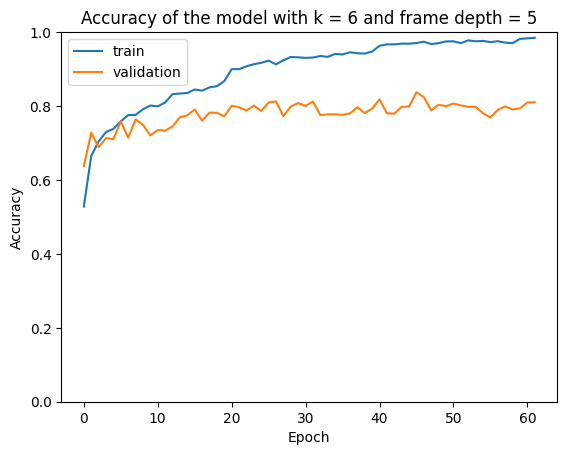

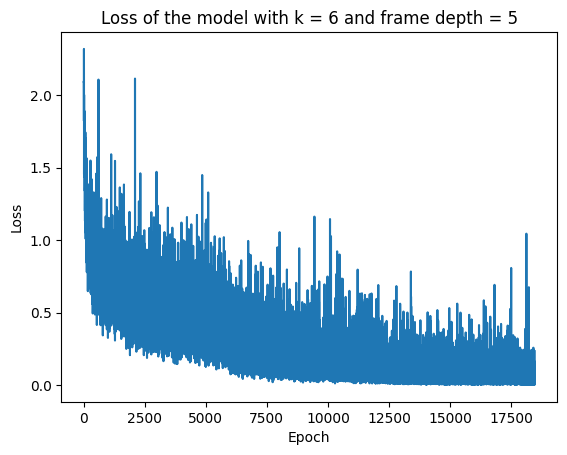

Training accuracy: 0.9846170055842377
Training loss: 0.23492618
Accuracy of the model with k = 6 and frame depth = 5: 0.8102
--- 2021.302634716034 seconds ---
evaluated: 0


In [28]:
# model_losses = []
# model_accuracies = []
models = []

for i, train_dataloader in enumerate(train_dataloaders):
    val_accuracies = []
    start_time = time.time()
    k = ks[i % len(ks)]
    model = Net(6, k=k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    augmentation_transformer = AugmentationTransformer(32)

    best_acc = -1
    losses = []
    accuracies = []
    for epoch in range(max_epoch):
        correct = 0
        count = 0
        model.train()
        for train_batch in train_dataloader:
            train_batch = train_batch.to(device)
            # train_batch = augmentation_transformer(train_batch)
            optimizer.zero_grad()
            out = model(train_batch)
            pred = out.argmax(dim=1)
            correct += (pred == train_batch.y).sum()
            loss = F.nll_loss(out, train_batch.y)
            losses.append(loss.detach())
            loss.backward()
            optimizer.step()
            count += len(train_batch)
        acc = int(correct) / count
        losses.append(loss.detach())
        accuracies.append(acc)
        scheduler.step()

        model.eval()
        val_correct = 0
        for val_batch in val_dataloaders[i]:
            val_batch = val_batch.to(device)
            pred = model(val_batch).argmax(dim=1)
            
            val_correct += (pred == val_batch.y).sum()
        val_acc = int(val_correct) / len(val_dataloaders[i].dataset)
        val_accuracies.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_acc_epoch = epoch
            last_improvement = 0
        else:
            last_improvement += 1

        if last_improvement > EARLY_STOPPING_PATIENCE:
            break
    
    models.append(model)
    torch.save(model, f"data/trained_model_k{k}_frame_depth{frame_depths[int(i/len(ks))]}_normalized_extended_chunk{num_chunks}.pt")
    losses = [tensor.cpu().numpy() for tensor in losses]
    # model_losses.append(losses)
    # model_accuracies.append(accuracies)
    print(f"trained: {i}")

    plt.plot(accuracies, label = "train")
    plt.plot(val_accuracies, label = "validation")
    plt.title(f"Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.ylim(0,1)
    plt.legend() 
    plt.show()

    plt.plot(losses)
    plt.title(f"Loss of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show()

    print("Training accuracy: "+str(accuracies[-1]))
    print("Training loss: "+str(losses[-1]))
    
    print(f'Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}: {val_accuracies[-1]:.4f}')
    print("--- %s seconds ---" % (time.time() - start_time))
    print(f"evaluated: {i}")

#### Evaluate the model on the test set

In [29]:
model.eval()
total_y_pred_label = []
total_y_true_label = []
correct = 0
wrong_four = []
for val_batch in test_dataloaders[i]:
    val_batch = val_batch.to(device)
    pred = model(val_batch).argmax(dim=1)
    
    total_y_pred_label.extend(pred)
    total_y_true_label.extend(val_batch.y)
    # batch_index = torch.tensor([p == 4 and y == 4 for p,y in zip(pred, val_batch.y)], device=device).nonzero()
    # batch_filter = torch.tensor([b in batch_index for b in val_batch.batch]).nonzero()
    # masked = val_batch.time[batch_filter].squeeze()
    # wrong_four.extend(torch.unique(masked))
    correct += (pred == val_batch.y).sum()
acc = int(correct) / len(test_graphs[i])
val_accuracies.append(acc)
print(f'Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}: {acc:.4f}')

Accuracy of the model with k = 6 and frame depth = 5: 0.7864


#### Confusion matrix

Text(0.5, 14.722222222222216, 'Predicated Label')

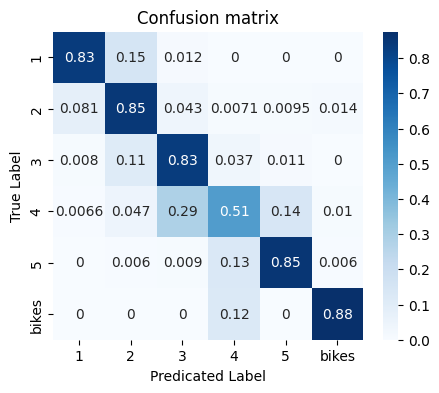

In [31]:
SHAPE_LABELS = [1,2,3,4,5,"bikes"]
total_y_pred = [pred_label.item() for pred_label in total_y_pred_label]
total_y_true = [true_label.item() for true_label in total_y_true_label]
cm = confusion_matrix(total_y_true, total_y_pred, labels=SHAPE_NAMES)
cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) 

df_cm = pd.DataFrame(cm, index = SHAPE_LABELS,
              columns = SHAPE_LABELS)
plt.figure(figsize = (5,4))
plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
figure = plot.get_figure()
plt.title("Confusion matrix")
plt.ylabel('True Label')
plt.xlabel('Predicated Label')

In [98]:
wrong_four_unique = np.unique([w.cpu().detach().numpy() for w in wrong_four])
print(wrong_four_unique)


[85676773 85676775 85676777 85676779 85676781 85676789 85676791 85676793
 85676795 85676797 85676799 85676801 85676803 85676981 85676983 85676985
 85676987 85676989 85676991 85677001 85677003 85677005 85677007 85677009
 85677011 85677013 85677015 85677017 85677019 85677027 85677029 85677031
 85677033 85677035 85679291 85679293 85679295 85679297 85679299 85679301
 85679303 85679305 85679307 85679315 85679317 85679319 85679321 85679323
 85679325 85679327 85679329 85679331 85679333 85679341 85679343 85679345
 85679477 85679479 85679481 85679483 85679485 85679487 85734207 85734209
 85734211 85734213 85734215 85734217 85734219 85734221 85734231 85734233
 85734235 85734237 85734239 85734241 85734243 85734245 85734247 85734423
 85734425 85734427 85734429 85734431 85734433 85734435 85734437 85734439
 85734447 85734449 85734451 85734453 85734455 85734457 85735725 85735727
 85735729 85735731 85735733 85735735 85735737 85735745 85735747 85735935
 85735937 85735939 85735941 85735943 85735945 85735

In [99]:
data_masked = all_data[all_data['current_frame'].isin(wrong_four_unique) ]
assert np.unique(data_masked['Label']) == [4]
masked_data_grouped = data_masked.groupby("current_frame")
print("Total number of frames: "+str(len(masked_data_grouped)))

masked_data_array = np.asarray([frame for (_, frame) in masked_data_grouped], dtype="object")
# Sort the data
sorted_masked_data = sorted(masked_data_array,key=lambda x:x["current_frame"].max(axis=0))

Total number of frames: 485


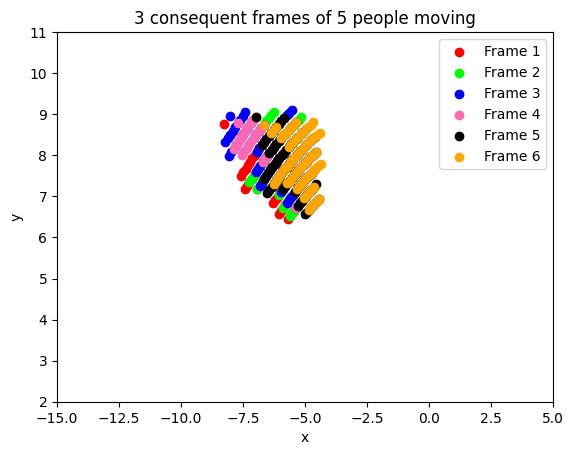

In [106]:
data = [frame.to_numpy() for frame in sorted_masked_data]
frame_num = 215
frame1 = data[frame_num]
frame2 = data[frame_num+1]
frame3 = data[frame_num+2]
frame4 = data[frame_num+3]
frame5 = data[frame_num+4]
frame6 = data[frame_num+5]
plt.scatter(frame1[:, 5], frame1[:, 4], c="red", label="Frame 1")
plt.scatter(frame2[:, 5], frame2[:, 4], c="lime", label="Frame 2")
plt.scatter(frame3[:, 5], frame3[:, 4], c="blue", label="Frame 3")
plt.scatter(frame4[:, 5], frame4[:, 4], c="hotpink", label="Frame 4")
plt.scatter(frame5[:, 5], frame5[:, 4], c="black", label="Frame 5")
plt.scatter(frame6[:, 5], frame6[:, 4], c="orange", label="Frame 6")
plt.legend()
plt.title("3 consequent frames of 5 people moving")
plt.ylabel("y")
plt.xlabel("x")
plt.xlim(-15, 5)
plt.ylim(2, 11)
plt.show()

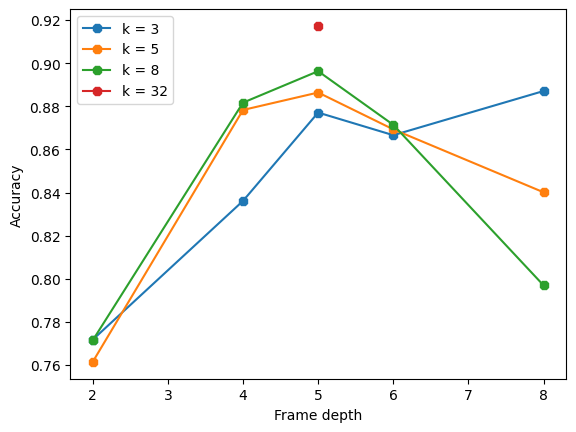

In [11]:
accuracies = np.array([0.7717, 0.7614, 0.7714,0.8361,0.8783,0.8817,0.8771,0.8864, 0.8963, 0.8666,0.8693,0.8714,0.8871,0.8401,0.7969])

frame_depths = [2,4,5,6,8]
ks =[3,5,8]
plt.plot(frame_depths, accuracies[[i*len(ks) for i in range(len(frame_depths))]], label = "k = 3", marker="8") 
plt.plot(frame_depths, accuracies[[i*len(ks)+1 for i in range(len(frame_depths))]], label = "k = 5", marker="8") 
plt.plot(frame_depths, accuracies[[i*len(ks)+2 for i in range(len(frame_depths))]], label = "k = 8", marker="8") 
plt.plot(5, 0.9173, label = "k = 32", marker="8") 
plt.xlabel("Frame depth")
plt.ylabel("Accuracy")
plt.legend() 
plt.show()

#### Distribution of the train data

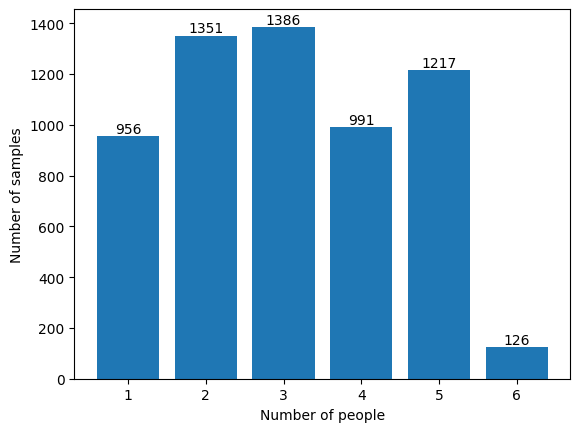

In [26]:
data_points = np.array([d.y.item() for d in train_graphs[0]])
zeros = len(np.where(data_points  == 0)[0])
ones = len(np.where(data_points  == 1)[0])
twos = len(np.where(data_points  == 2)[0])
threes = len(np.where(data_points  == 3)[0]) 
fours = len(np.where(data_points  == 4)[0])
bikes = len(np.where(data_points  == 5)[0])

labels = [1,2,3,4,5, 6]
sample_num = [zeros, ones, twos, threes, fours,bikes]
p = plt.bar(labels, sample_num)
plt.xlabel("Number of people")
plt.ylabel("Number of samples")
plt.bar_label(p)
plt.show()